In [180]:
import pandas as pd
import networkx as nx
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from networkx.algorithms.community import modularity_max
from tabulate import tabulate
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity
import csv
import cartopy.crs as ccrs
import cartopy.feature as cfeature


In [179]:
!pip install xlsxwriter
!pip install geopandas
!pip install contextily

^C


In [ ]:
!pip install Cartopy
!pip install shapely matplotlib


  Obtaining dependency information for Cartopy from https://files.pythonhosted.org/packages/4f/ce/ba4baced164ecd78b4109cd611d7b64d256f012784e944c1b0f6f5dff5c1/Cartopy-0.24.1-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for pyshp>=2.3 from https://files.pythonhosted.org/packages/98/2f/68116db5b36b895c0450e3072b8cb6c2fac0359279b182ea97014d3c8ac0/pyshp-2.3.1-py2.py3-none-any.whl.metadata
     ---------------------------------------- 0.0/56.0 kB ? eta -:--:--
     ---------------------------------------- 0.0/56.0 kB ? eta -:--:--
     ------- -------------------------------- 10.2/56.0 kB ? eta -:--:--
     -------------------- ----------------- 30.7/56.0 kB 435.7 kB/s eta 0:00:01
     -------------------------------------- 56.0/56.0 kB 486.5 kB/s eta 0:00:00
   ---------------------------------------- 0.0/11.0 MB ? eta -:--:--
    --------------------------------------- 0.2/11.0 MB 5.3 MB/s eta 0:00:03
   --- ------------------------------------ 0.8/11.0 MB 10.5 MB

In [181]:
df = pd.read_csv('Psittaciformes.csv')

In [182]:
basic_columns_list = [
    'scientificName',
    'familyName',
    'orderName',

    'Beak.Length_Culmen',
    'Beak.Length_Nares',
    'Beak.Width',
    'Beak.Depth',
    'Tarsus.Length',
    'Wing.Length',
    'Kipps.Distance',
    'Hand-Wing.Index',
    'Tail.Length',
    'Mass',

    'Habitat', 
    'Habitat.Density',
    'Migration',
    'Trophic.Level', 
    'Trophic.Niche', 
    'Primary.Lifestyle',
    
    'Min.Latitude',
    'Max.Latitude',
    'Centroid.Latitude',
    'Centroid.Longitude',
    'Range.Size',


    'redlistCategory',
    'populationTrend',

]

df = df[basic_columns_list]

In [183]:
Ecological_features = [ 
    'Habitat', 
    'Habitat.Density',
    'Migration',
    'Trophic.Level', 
    'Trophic.Niche', 
    'Primary.Lifestyle'
]

In [184]:
def encoded_Ecological_features(df):

    categorical_columns = ['Habitat', 'Trophic.Level', 'Trophic.Niche', 'Primary.Lifestyle']
    
    # Apply one-hot encoding
    encoded_data = pd.get_dummies(df[categorical_columns], prefix=categorical_columns)

    # Add Habitat.Density and  Migration (numerical column) to the encoded data
    encoded_data['Habitat.Density'] = df['Habitat.Density']
    encoded_data['Migration'] = df['Migration']
    
    #Add species_names to the encoded data
    encoded_data['species_names'] = df['scientificName'].values
    
    return encoded_data


In [185]:
def compute_similarity(encoded_data, categorical_weight, numeric_weight):
    
    """
    Compute cosine similarity between species's ecological features and ensure values are in [-1,1] range.

    Parameters:
        encoded_data: numpy array of encoded ecological features
        categorical_weight: weights for attributes: 'Habitat', 'Trophic.Level', 'Trophic.Niche', 'Primary.Lifestyle'
        numberic_weight: weights for attributes: 'Habitat.Density', 'Migration'.
    Returns:   
        similarity_matrix: numpy array of pairwise similarities
    """

    # Get the number of species (rows) in the dataset
    num_species = len(encoded_data)

    # Initialize an empty similarity matrix
    similarity_matrix = np.zeros((num_species, num_species))

  
    # Compute weighted similarity
    for i in range(num_species):
        for j in range(num_species):
            # Binary similarity for categorical features
            categorical_similarity = categorical_weight * np.sum(
                encoded_data.iloc[i, :-2] == encoded_data.iloc[j, :-2]  # Exclude Habitat.Density
            )
            
            # Numerical similarity for Habitat.Density (scaled by weight)
            density_similarity = numeric_weight * (1 - abs(encoded_data['Habitat.Density'].iloc[i] - encoded_data['Habitat.Density'].iloc[j]) / encoded_data['Habitat.Density'].max())
            migration_similarity = numeric_weight * (1 - abs(encoded_data['Migration'].iloc[i] - encoded_data['Migration'].iloc[j]) / encoded_data['Migration'].max())
            
            # Aggregate similarities
            similarity_matrix[i, j] = categorical_similarity + density_similarity + migration_similarity

    return similarity_matrix

In [186]:
# Visualize similarity distribution
def plot_similarity_distribution(similarity_matrix):
    """
    Plot the distribution of similarity values to help with thresholding
    """
    plt.figure(figsize=(10, 6))
    # Get upper triangle values
    upper_tri = similarity_matrix[np.triu_indices(len(similarity_matrix), k=1)]

    plt.hist(upper_tri, bins=50)
    plt.title('Distribution of Similarity Values')
    plt.xlabel('Similarity')
    plt.ylabel('count')


In [187]:
#Creat network based on knn method
def create_knn_network(similarity_matrix, species_names, df_data, k=5):
    """
    Create network with node attributes and k-nearest neighbor connections.
    Prevents self-loops and ensures proper KNN connections.
    
    Parameters:
        similarity_matrix: Matrix of pairwise species similarities
        species_names: List of species names
        df_data: DataFrame containing species attributes (latitude, longitude, family, etc.)
        k: Number of nearest neighbors to connect for each node
    """
    G_knn = nx.Graph()

    # Add nodes with attributes
    for species in species_names:
        # Get species data from DataFrame
        species_data = df_data[df_data['scientificName'] == species].iloc[0]

        # Add node with relevant attributes
        G_knn.add_node(
            species,
            latitude=species_data['Centroid.Latitude'],
            longitude=species_data['Centroid.Longitude'],
            habitat=species_data['Habitat'],
            migration=species_data['Migration'],
            trophic_level=species_data['Trophic.Level'],
            trophic_niche=species_data['Trophic.Niche'],
            primary_lifestyle=species_data['Primary.Lifestyle'],
            family=species_data['familyName'],
            scientific_name=species
        )

    # Create a mask for the diagonal to exclude self-connections
    np.fill_diagonal(similarity_matrix, -np.inf)  # Set diagonal to negative infinity

    # Add edges based on k-nearest neighbors
    for i in range(len(species_names)):
        # Get indices of k most similar species (excluding self)
        similarities = similarity_matrix[i]
        # Argsort in descending order (most similar first)
        most_similar_indices = np.argsort(similarities)[::-1][:k]

        # Add edges to k nearest neighbors
        for j in most_similar_indices:
            G_knn.add_edge(
                species_names[i],
                species_names[j],
                weight=similarity_matrix[i][j]
            )

    # Check for self-loops
    self_loops = list(nx.selfloop_edges(G_knn))
    if self_loops:
        print("Warning: Self-loops found in the network:")
        for edge in self_loops:
            print(f"Self-loop found for node: {edge[0]}")
    else:
        print("No self-loops found in the network")

    # Additional network statistics
    print(f"\nNetwork Statistics:")
    print(f"Number of nodes: {G_knn.number_of_nodes()}")
    print(f"Number of edges: {G_knn.number_of_edges()}")
    print(f"Average degree: {sum(dict(G_knn.degree()).values()) / G_knn.number_of_nodes():.2f}")
    print(f"Network density: {nx.density(G_knn):.4f}")
    
    return G_knn

In [188]:
def visualize_and_save_knn_network(G_knn, output_filename="knn_network.gml", zoom_factor=1.5):
    """
    Visualizes the KNN network with a zoom effect and saves it as a GML file.
    
    Parameters:
        G_knn (networkx.Graph): The KNN graph to visualize.
        output_filename (str): The name of the output GML file. Defaults to "knn_network.gml".
        zoom_factor (float): A factor to zoom into the network. Default is 1.5.
    """
    # Set up a larger figure to make it zoomed in
    plt.figure(figsize=(12, 10))

    # Choose a layout for better visualization
    pos = nx.spring_layout(G_knn, k=zoom_factor, seed=42)  # Adjusting the spring layout for zoom effect

    # Draw the network
    nx.draw(G_knn, pos, with_labels=False, node_size=70, node_color="skyblue", font_size=12, font_weight="bold", edge_color="gray")

    # Set the title
    plt.title("Zoomed-in KNN Network Visualization", fontsize=16)

    # Display the plot
    plt.show()

    # Save the network to a GML file
    nx.write_gml(G_knn, output_filename)

    print(f"Network saved as {output_filename}")


In [189]:
def detect_communities(G):
    """
    Detect communities in a network using Louvain modularity maximization.

    Parameters:
        G: NetworkX Graph object.

    Returns:
        Dictionary mapping nodes to their community ID.
    """
    communities = modularity_max.greedy_modularity_communities(G)
    community_mapping = {}
    for community_id, community_nodes in enumerate(communities):
        for node in community_nodes:
            community_mapping[node] = community_id
    return community_mapping


In [190]:
def visualize_communities(G, layout='spring'):
    """
    Visualize the network with nodes colored by community.

    Parameters:
        G: NetworkX Graph object.
        layout: Layout for positioning nodes ('spring', 'circular', etc.).
    """
    # Choose layout
    if layout == 'spring':
        pos = nx.spring_layout(G)
    elif layout == 'circular':
        pos = nx.circular_layout(G)
    else:
        pos = nx.random_layout(G)

    # Get community colors
    communities = nx.get_node_attributes(G, "community")
    unique_communities = set(communities.values())
    colors = list(mcolors.TABLEAU_COLORS.values())  # Get a list of distinct colors

    # Draw nodes
    for community_id in unique_communities:
        community_nodes = [node for node in G if communities[node] == community_id]
        nx.draw_networkx_nodes(G, pos, nodelist=community_nodes,
                               node_color=colors[community_id % len(colors)],
                               label=f"Community {community_id}")

    # Draw edges
    nx.draw_networkx_edges(G, pos, alpha=0.5)

    # Add labels and legend
    plt.title("Network Visualization with Communities")
    plt.legend()
    plt.show()


In [191]:
def analyze_community(G, community_dict, community_id):
    # Get nodes in the community
    community_nodes = [node for node, comm_id in community_dict.items() if comm_id == community_id]
    
    # Create subgraph for the community
    subgraph = G.subgraph(community_nodes)
    
    # Check for disconnected components
    components = list(nx.connected_components(subgraph))
    largest_component = max(components, key=len)  # Get the largest connected component
    subgraph = subgraph.subgraph(largest_component)  # Focus on the largest component
    
    # Calculate centrality measures
    degree_centrality = nx.degree_centrality(subgraph)
    closeness_centrality = nx.closeness_centrality(subgraph)
    betweenness_centrality = nx.betweenness_centrality(subgraph)
    
    # Handle eigenvector centrality with try-except to catch convergence issues
    try:
        eigenvector_centrality = nx.eigenvector_centrality(subgraph)
    except nx.PowerIterationFailedConvergence:
        print(f"Eigenvector centrality calculation failed for community {community_id}")
        eigenvector_centrality = {}  # Assign empty dictionary if failed
    
    # Calculate additional metrics
    clustering_coefficient = nx.clustering(subgraph)
    avg_path_length = nx.average_shortest_path_length(subgraph) if nx.is_connected(subgraph) else float('inf')
    
    # Print out the results
    print(f"Community {community_id} Analysis:")
    print("Degree Centrality:", degree_centrality)
    print("Closeness Centrality:", closeness_centrality)
    print("Betweenness Centrality:", betweenness_centrality)
    print("Eigenvector Centrality:", eigenvector_centrality)
    print("Clustering Coefficient:", clustering_coefficient)
    print(f"Average Path Length: {avg_path_length}")
    print("="*50)
    
    return {
        'degree_centrality': degree_centrality,
        'closeness_centrality': closeness_centrality,
        'betweenness_centrality': betweenness_centrality,
        'eigenvector_centrality': eigenvector_centrality,
        'clustering_coefficient': clustering_coefficient,
        'avg_path_length': avg_path_length
    }


In [ ]:
def visualize_communities_and_analysis(G, community_mapping):
    """
    Visualize each community in the network along with its summarized analysis results displayed as a text box.

    Parameters:
        G: NetworkX graph
        community_mapping: Dictionary mapping nodes to their community IDs
    """
    # Extract unique communities
    communities = list(set(community_mapping.values()))
    num_communities = len(communities)
    
    # Set up the subplots: Adjust figsize for the number of communities
    fig, axes = plt.subplots(nrows=num_communities, ncols=1, figsize=(10, 5 * num_communities))

    # Ensure axes is always a list for consistent indexing
    if num_communities == 1:
        axes = [axes]
    
    # Loop through communities
    for idx, community in enumerate(communities):
        community_nodes = [node for node, comm in community_mapping.items() if comm == community]
        subgraph = G.subgraph(community_nodes)

        # Analysis function: Replace with your actual analysis or use this sample
        degree_centrality = nx.degree_centrality(subgraph)
        closeness_centrality = nx.closeness_centrality(subgraph)
        betweenness_centrality = nx.betweenness_centrality(subgraph)
        clustering_coefficient = nx.clustering(subgraph)

        avg_path_length = (
            nx.average_shortest_path_length(subgraph)
            if nx.is_connected(subgraph)
            else float('inf')
        )

        # Compute summaries for each metric
        def summarize_metric(metric):
            return {
                "mean": np.mean(list(metric.values())),
                "max": np.max(list(metric.values())),
                "min": np.min(list(metric.values())),
            }

        degree_summary = summarize_metric(degree_centrality)
        closeness_summary = summarize_metric(closeness_centrality)
        betweenness_summary = summarize_metric(betweenness_centrality)
        clustering_summary = summarize_metric(clustering_coefficient)

        # Plot the subgraph
        ax = axes[idx]
        pos = nx.spring_layout(subgraph)  # Change layout as needed
        nx.draw(
            subgraph, pos, ax=ax, with_labels=False, node_size=50, font_size=8,
            node_color='skyblue', edge_color='gray'
        )
        ax.set_title(f"Community {community} Visualization", fontsize=14)

        # Format analysis results into a readable string
        analysis_str = (
            f"Community {community} Analysis:\n"
            f"Degree Centrality (Mean/Max/Min): {degree_summary['mean']:.2f}/{degree_summary['max']:.2f}/{degree_summary['min']:.2f}\n"
            f"Closeness Centrality (Mean/Max/Min): {closeness_summary['mean']:.2f}/{closeness_summary['max']:.2f}/{closeness_summary['min']:.2f}\n"
            f"Betweenness Centrality (Mean/Max/Min): {betweenness_summary['mean']:.2f}/{betweenness_summary['max']:.2f}/{betweenness_summary['min']:.2f}\n"
            f"Clustering Coefficient (Mean/Max/Min): {clustering_summary['mean']:.2f}/{clustering_summary['max']:.2f}/{clustering_summary['min']:.2f}\n"
            f"Average Path Length: {avg_path_length:.2f}\n"
        )
        
        # Add the analysis text box to the plot
        ax.text(
            0.05, 0.95, analysis_str, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', horizontalalignment='left',
            bbox=dict(facecolor='white', alpha=0.7)
        )

    # Adjust layout
    plt.tight_layout()
    plt.show()


In [193]:
def plot_network_on_map(G, community_dict, title="Ecological Network on Geographical Map"):
    """
    Plot an ecological network on a geographical map with nodes colored by community.
    
    Parameters:
        G: NetworkX graph with nodes containing latitude and longitude attributes
        community_dict: Dictionary with nodes as keys and community IDs as values
        title: Title of the map
    """
    # Create a Cartopy map using PlateCarree projection (lat-lon)
    fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})
    ax.set_extent([-180, 180, -60, 90])  # Longitude and latitude bounds
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.add_feature(cfeature.COASTLINE, edgecolor='black')
    ax.add_feature(cfeature.BORDERS, edgecolor='black')
    ax.set_title(title, fontsize=16)

    # Assign random colors to communities
    community_colors = {community: (random.random(), random.random(), random.random())
                        for community in set(community_dict.values())}

    # Plot nodes
    for node in G.nodes:
        # Get latitude and longitude from node attributes
        lat = G.nodes[node]['latitude']
        lon = G.nodes[node]['longitude']
        community = community_dict[node]

        # Plot the node on the map
        ax.scatter(lon, lat, s=50, c=[community_colors[community]], edgecolor='black', zorder=5,
                   transform=ccrs.PlateCarree())

    # Plot edges
    for u, v in G.edges:
        # Get latitudes and longitudes of the nodes
        lat_u, lon_u = G.nodes[u]['latitude'], G.nodes[u]['longitude']
        lat_v, lon_v = G.nodes[v]['latitude'], G.nodes[v]['longitude']

        # Plot the edge as a line
        ax.plot([lon_u, lon_v], [lat_u, lat_v], color='gray', alpha=0.5, linewidth=0.5, zorder=4,
                transform=ccrs.PlateCarree())

    legend_labels = [f"Community {community}" for community in community_colors]
    legend_handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10)
                      for color in community_colors.values()]
    
    ax.legend(handles=legend_handles, labels=legend_labels, loc='upper left', title="Community Legend")


    # Show plot
    plt.show()


In [194]:
#Data Preparation
df_feature = df[['scientificName'] + Ecological_features].copy()
df_feature = df_feature.dropna()

#Encode Catergorical Features into Binary Format
encoded_features = encoded_Ecological_features(df_feature)

# Compute weighted similarity
ecological_features_similarity_matrix = compute_similarity(encoded_features, categorical_weight=1, numeric_weight=0.5)


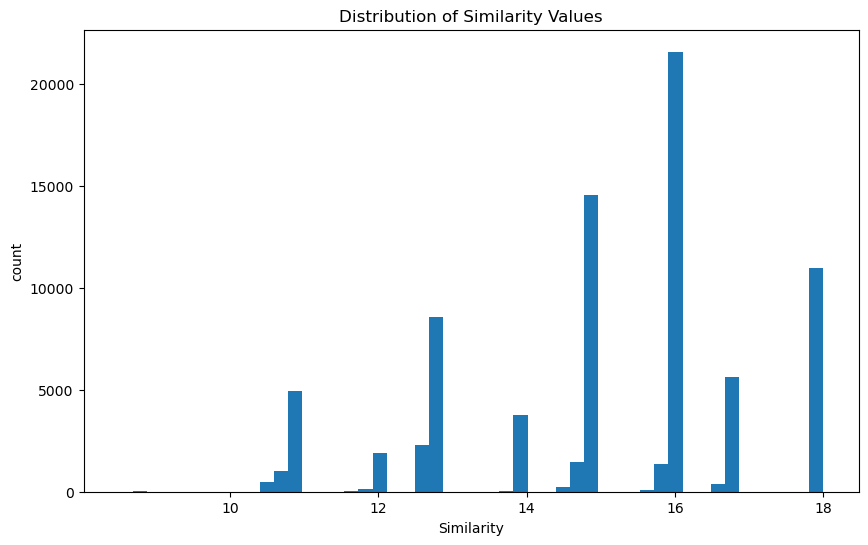

In [195]:
plot_similarity_distribution(ecological_features_similarity_matrix)

In [196]:
# create the network
species=df_feature['scientificName'].tolist()

G_knn = create_knn_network(
        similarity_matrix=ecological_features_similarity_matrix,
        species_names = species,
        df_data=df,
        k=5
)
 


No self-loops found in the network

Network Statistics:
Number of nodes: 399
Number of edges: 1763
Average degree: 8.84
Network density: 0.0222


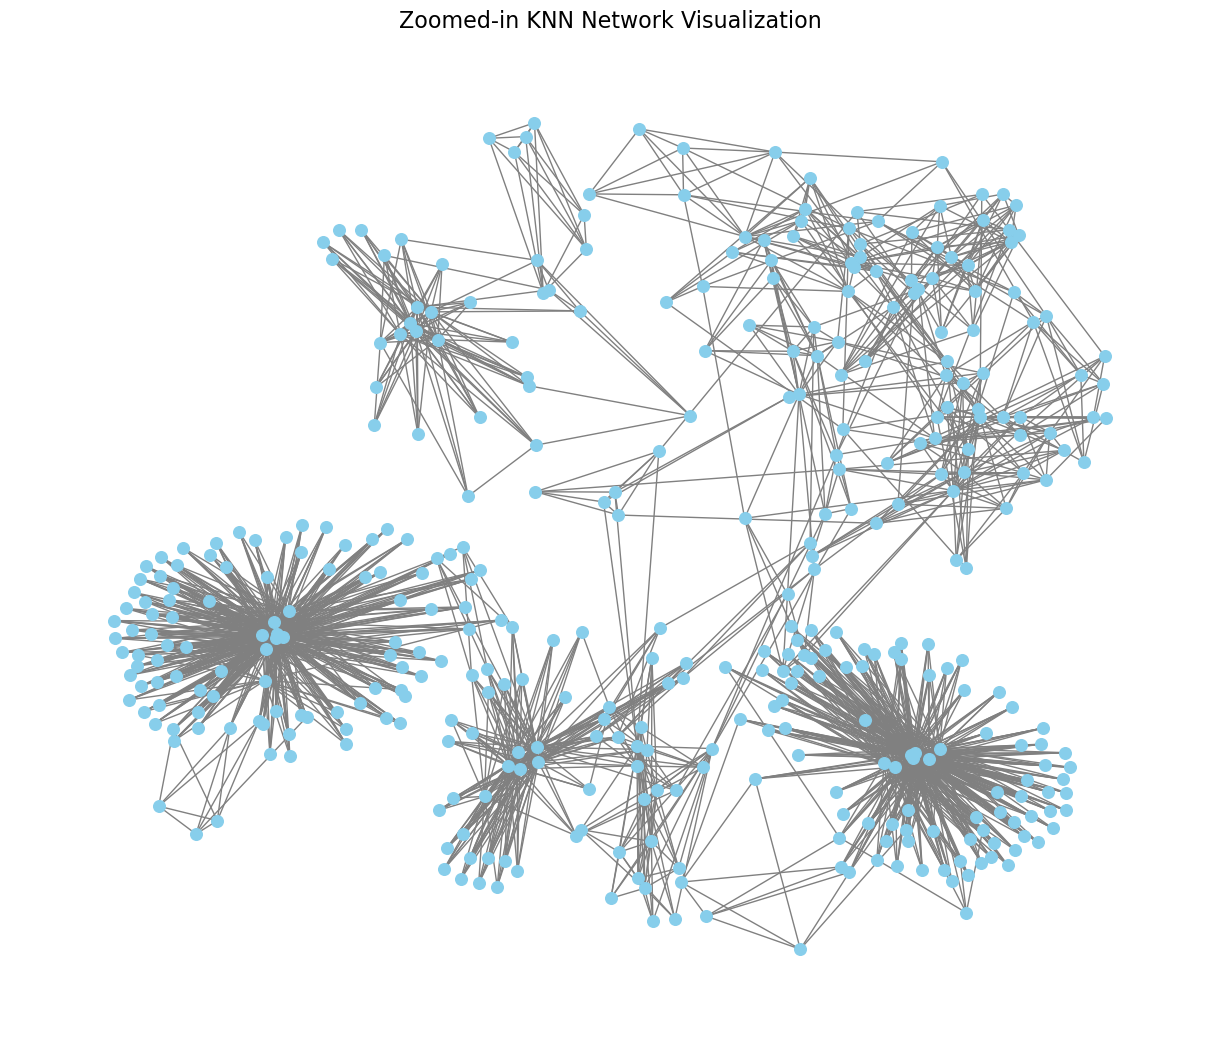

Network saved as Ecological_Co-ourrence Network.gml


In [197]:
visualize_and_save_knn_network(G_knn, output_filename="Ecological_Co-ourrence Network.gml", zoom_factor=0.7)

In [198]:
# Detect communities
community_mapping = detect_communities(G_knn)

# Assign communities as node attributes
nx.set_node_attributes(G_knn, community_mapping, "community")


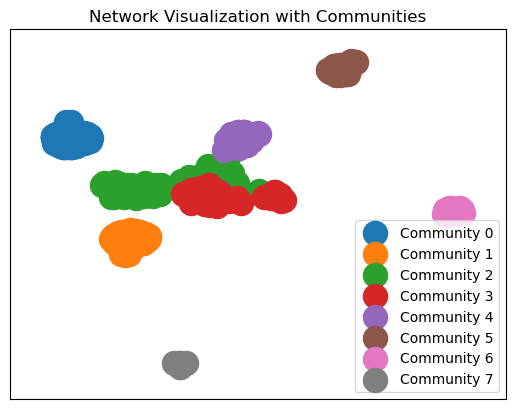

In [199]:
visualize_communities(G_knn, layout='spring')

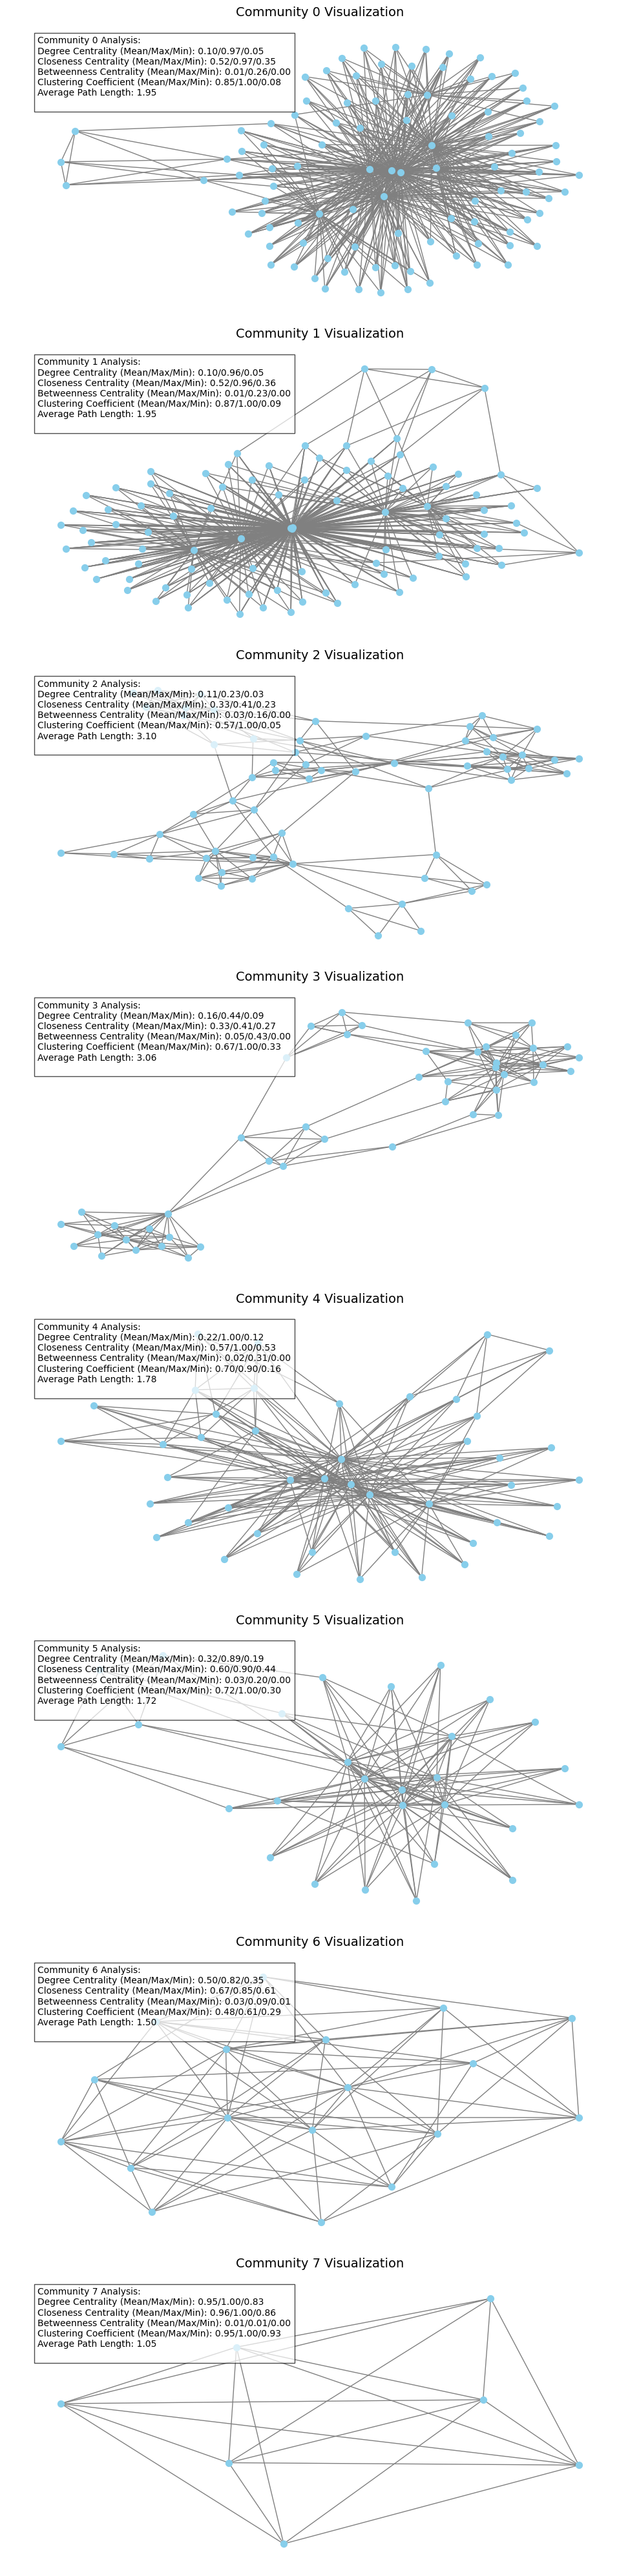

In [203]:
#visualize each community and display the analysis for each
visualize_communities_and_analysis(G_knn, community_mapping)


d:\App\python\Lib\site-packages\pyproj\transformer.py:817: UserWarning:


d:\App\python\Lib\site-packages\pyproj\transformer.py:817: UserWarning:


d:\App\python\Lib\site-packages\pyproj\transformer.py:817: UserWarning:


d:\App\python\Lib\site-packages\pyproj\transformer.py:817: UserWarning:


d:\App\python\Lib\site-packages\pyproj\transformer.py:817: UserWarning:


d:\App\python\Lib\site-packages\pyproj\transformer.py:817: UserWarning:


d:\App\python\Lib\site-packages\pyproj\transformer.py:817: UserWarning:


d:\App\python\Lib\site-packages\pyproj\transformer.py:817: UserWarning:


d:\App\python\Lib\site-packages\pyproj\transformer.py:817: UserWarning:




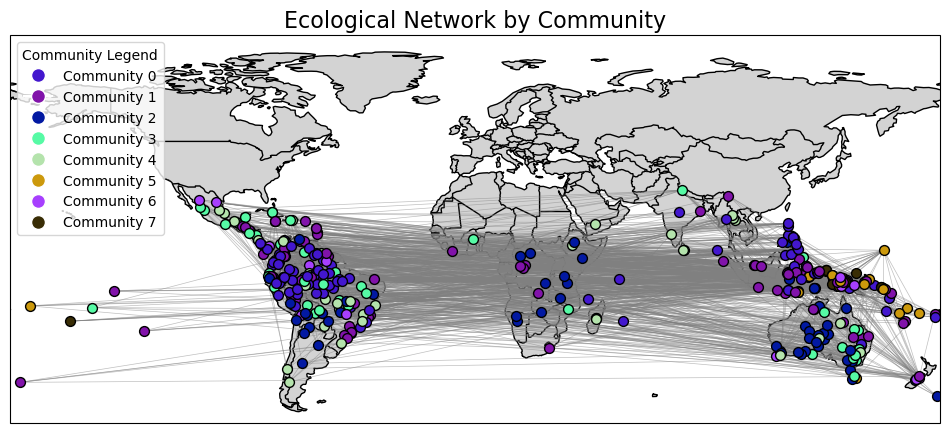

In [204]:
# Plot the network on a map
plot_network_on_map(G_knn, community_mapping, title="Ecological Network by Community")

In [ ]:

# Add community information to each node
for node, community_id in community_mapping.items():
        G_knn.nodes[node]['community'] = community_id

# Save the graph to a GML file
nx.write_gml(G_knn, "Ecological_network_with_communities.gml")

print("Graph with communities saved as Ecological_network_with_communities.gml")